In [3]:
import pytest
import numpy as np
import scipy as sp


from scipy.misc import imread, imshow
from scipy.ndimage import affine_transform

from matplotlib import pyplot as plt

%matplotlib inline

In [7]:
### Metrics
def MSE(x, y, axis=None):
    return np.mean((x - y)**2)

def MAE(x, y, axis=None):
    return np.mean(np.abs(x - y))


### Function for computing affine transform in any dimension and metrics for images
def augment(points):
    return np.hstack([points, np.ones((points.shape[0], 1))])

def compute_affine_transform(X, Y):
    affine_mat = np.linalg.lstsq(augment(X), augment(Y))[0].T
    mat, shift = affine_mat[:-1, :-1], affine_mat[:-1, -1]
    #print((mat @ X.T) + shift[:, None] - Y.T)
    return mat, shift

def closest_values(grid, points, default=0, return_mask=False):
    intpoints = np.array(np.round(points), dtype=np.int)
    default_mask = np.logical_or(np.logical_or(intpoints[0] < 0, intpoints[0] >= grid.shape[0]),
                                 np.logical_or(intpoints[1] < 0, intpoints[1] >= grid.shape[1]))
    res = np.zeros(intpoints.shape[1], dtype=np.float)
    res[default_mask] = default
    res[~default_mask] = grid[intpoints[0][~default_mask], intpoints[1][~default_mask]]
    if return_mask:
        return res, ~default_mask
    else:
        return res

def to_index(mat):
    return np.stack((np.repeat(np.arange(mat.shape[0]), mat.shape[1]),
                     np.tile(np.arange(mat.shape[1]), mat.shape[0])), axis=0)

def combine_images(images, points_sets, crop=False):
    img_from, img_to = images
    ps_from, ps_to = points_sets
    
    # should swap points coordinates to match shapes of images (were reversed)
    mat, shift = compute_affine_transform(ps_to[:, ::-1], ps_from[:, ::-1])
    
    # create bigger image matrix that is able to store combined image
    img_placeholder = np.zeros((images[0].shape[0]*5, images[0].shape[1]*5))
    mask = np.zeros_like(img_placeholder, dtype=np.bool)
    
    # Define a shift of img_to inside a big image.
    shifts = np.array([2 * images[1].shape[0], 2 * images[1].shape[1]])
    
    # We then need to compute relative indices to img_to for all indices of big image
    # and transform these relative indices with our fitted affine transformation
    # to obtain indices in img_from to retrieve pixel values.
    idx = to_index(img_placeholder)
    idx -= shifts[:, None]
    pre_indices = mat @ idx + shift[:, None]
    idx += shifts[:, None]

    # compute pixel values and mask (if this pixel lies inside a img_from) by float coordinates (we will use nearest pixel value)
    cvs, cvs_mask = closest_values(img_from, pre_indices, return_mask=True)

    # insert transformed img_from into a big image.
    # mask defines if pixels are from and image
    img_placeholder[:, :] = cvs.reshape(img_placeholder.shape)
    mask[:, :] = cvs_mask.reshape(img_placeholder.shape)
    
    # insert img_to to a center of big image
    img_placeholder[shifts[0]: shifts[0] + img_to.shape[0], shifts[1]: shifts[1] + img_to.shape[1]] = img_to[:, :]
    mask[shifts[0]: shifts[0] + img_to.shape[0], shifts[1]: shifts[1] + img_to.shape[1]] = True
    
    # crop big image by a minimal rectangle contains combined image, if needed.
    if crop:
        nonzeros = np.where(mask == True)
        ilow, ihigh = nonzeros[0].min(), nonzeros[0].max() + 1
        jlow, jhigh = nonzeros[1].min(), nonzeros[1].max() + 1
        return img_placeholder[ilow: ihigh, jlow:jhigh]
    else:
        return img_placeholder

def test_combine_images():
    corr0 = np.loadtxt('correspondence2D_w0.txt')
    corr1 = np.loadtxt('correspondence2D_w1.txt')

    w0 = imread('w0.png')
    w1 = imread('w1.png')
    img = combine_images((w0, w1), (corr0, corr1), crop=True)
    plt.imshow(img.astype(np.uint8), cmap='gray')
    # remove plt.show() to stop tests running from interrupting
    plt.savefig('test_combined.png')
    #plt.show()

def test_affine3d():
    corr0 = np.loadtxt('correspondence3D_1.txt')
    corr1 = np.loadtxt('correspondence3D_2.txt')
    
    mat, shift = compute_affine_transform(corr0, corr1)
    corr0_transformed = (np.linalg.pinv(mat) @ corr0.T - shift[::, None]).T - corr1
    print("MSE on transformed points: {}".format(MSE(corr0_transformed, corr1)))

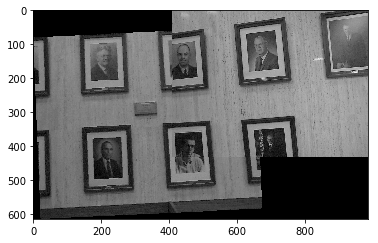

In [8]:
test_combine_images()